# Simulataneous Fitting in iminuit

This notebook demonstrates how to simulataneously fit two datasets, where the distributions have shared paramters, through the use of `CostSum`.

In [1]:
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL
from iminuit.util import make_func_code
from matplotlib import pyplot as plt
import numpy as np
from numpy.random import randn, seed
from numba import vectorize, float64
from math import exp, sqrt, pi

In [2]:
# Define the PDF
SQRT2PI = sqrt(2.0 * pi)

@vectorize([float64(float64, float64, float64)], fastmath=True)
def normal_pdf(x, mean, std_deviation):
    u = (x - mean) / std_deviation
    return exp(-0.5 * u ** 2) / (SQRT2PI * std_deviation)
normal_pdf.func_code = make_func_code(("x", "mu", "sigma"))

In [3]:
# Generate some appropriate data
seed(0)
width = 2.0
data1 = randn(1000) * width + 1
data2 = randn(1000) * width + 2

In [4]:
# Create the cost functions, and rename the non-shared parameters 
lh1 = UnbinnedNLL(data1, normal_pdf)
lh1.rename_parameter("mu", "mu_1")
lh2 = UnbinnedNLL(data2, normal_pdf)
lh2.rename_parameter("mu", "mu_2")

simlh = lh1 + lh2  # Sum the cost functions to produce the `CostSum`
m = Minuit(simlh, mu_1=0.2, mu_2=2.2, sigma=1.5)

In [5]:
def plot(cost, minuit, i, ax):
    maps_i = cost.maps[i]
    names_i = [minuit.parameters[p] for p in maps_i]
    values_i = [minuit.values[p] for p in maps_i]
    errors_i = [minuit.errors[p] for p in maps_i]
    data_i = cost[i].data
    bins, edges = np.histogram(data_i, bins=100)
    mid = (edges[1:] + edges[:-1]) / 2
    binwidth = (edges[1] - edges[0])
    ax.errorbar(mid, bins, np.sqrt(bins), fmt="b.", capsize=0, zorder=0)
    y = normal_pdf(mid, *values_i) * np.sum(bins * binwidth)
    ax.plot(mid, y)
    t = ""
    for n, v, e in zip(names_i, values_i, errors_i):
        t += f"{n} = {v:.3f} ± {e:.3f}\n"
    ax.text(0.01, 0.99, t, transform=ax.transAxes, va='top')

Text(0.5, 0.98, 'After')

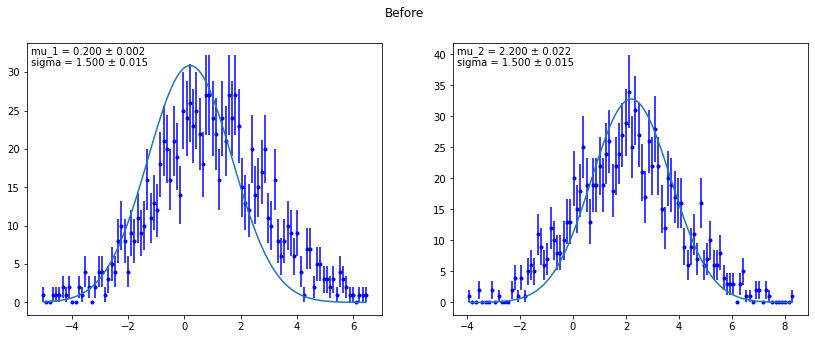

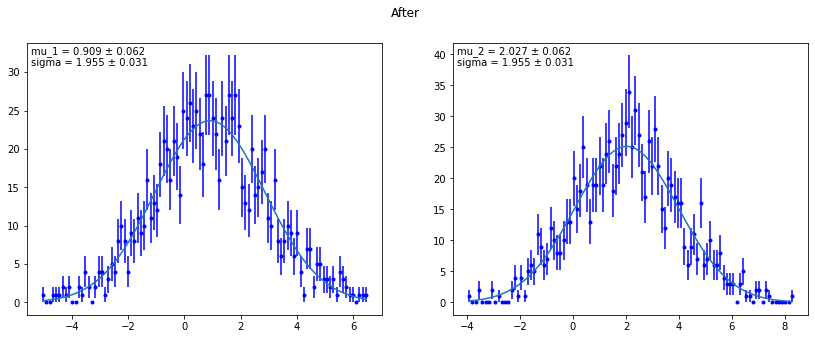

In [6]:
# Plot distributions before and after minimisation
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
plot(simlh, m, 0, ax1)
plot(simlh, m, 1, ax2)
fig.suptitle("Before")

m.migrad()  # fit

fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
plot(simlh, m, 0, ax1)
plot(simlh, m, 1, ax2)
fig.suptitle("After")